# Hepatitis C Prediction Dataset
The dataset contains laboratory values of blood donors and Hepatitis C patients and demographic values like age. 

**Content**

All attributes except Category and Sex are numerical.

*Attributes 1 to 4 refer to the data of the patient:*
1) X (Patient ID/No.)
2) Category (diagnosis) (values: '0=Blood Donor', '0s=suspect Blood Donor', '1=Hepatitis', '2=Fibrosis', '3=Cirrhosis')
3) Age (in years)
4) Sex (f,m)

*Attributes 5 to 14 refer to laboratory data:*

5) ALB   -  albumin
6) ALP   -  alkaline phosphatase
7) ALT   -  alanine aminotransferase
8) AST   -  aspartate aminotransferase
9) BIL   -  bilirubin
10) CHE  -  cholinesterase
11) CHOL -  lipid profile
12) CREA -  creatinine
13) GGT  -  gamma-glutamyl transpeptidase
14) PROT -  proteins

The target attribute for classification is Category (2): blood donors vs. Hepatitis C patients (including its progress ('just' Hepatitis C, Fibrosis, Cirrhosis).

In [72]:
#The libraries are loading.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import  RandomizedSearchCV, train_test_split , GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from mlxtend.plotting import plot_confusion_matrix

In [73]:
data=pd.read_csv('HepatitisCdata.csv')

In [74]:
data.head(-1)

,Unnamed: 0,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,1,0=Blood Donor,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,2,0=Blood Donor,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,3,0=Blood Donor,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,4,0=Blood Donor,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,5,0=Blood Donor,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,610,3=Cirrhosis,59,f,39.0,51.3,19.6,285.8,40.0,5.77,4.51,136.1,101.1,70.5
610,611,3=Cirrhosis,62,f,32.0,416.6,5.9,110.3,50.0,5.57,6.30,55.7,650.9,68.5
611,612,3=Cirrhosis,64,f,24.0,102.8,2.9,44.4,20.0,1.54,3.02,63.0,35.9,71.3
612,613,3=Cirrhosis,64,f,29.0,87.3,3.5,99.0,48.0,1.66,3.63,66.7,64.2,82.0


In [75]:
#As we can see, the ‘Unnamed’ column is not necessary for the analysis as it does not provide relevant information. 
# So, we will drop this column from the dataset.
data = data.drop(columns=['Unnamed: 0'])

In [76]:
#In addition, it is necessary to encode the Sex variable. 
#.map function will be used to convert 'm' to 0 and 'f' to 1.
data['Sex'] = data['Sex'].map({'m': 0, 'f': 1}).astype('Int64')
# It is verified that the encoding has been done correctly.
data['Sex'].value_counts(dropna=False)          

Sex
0    377
1    238
Name: count, dtype: Int64

In [77]:
# The same is done for the Category variable. Where '0=Blood Donor' and '0s=suspect Blood Donor' are mapped to 0 (healthy)
# and the rest to 1 (sick). 
data['Category'] = data['Category'].map({'0=Blood Donor': 0,'0s=suspect Blood Donor': 0, 
                                         "1=Hepatitis": 1, '2=Fibrosis': 1, '3=Cirrhosis': 1}).astype('Int64')
data['Category'].value_counts(dropna=False)                      

Category
0    540
1     75
Name: count, dtype: Int64

In [78]:
#Now, we review the statistical data of each column to see if any other preprocessing is necessary.
def check_data(dataframe, head=5):
  print(dataframe.shape) 
  print(dataframe.dtypes)
  print(dataframe.isnull().sum())
  print(dataframe.describe(include="all"))
  print(dataframe.count()) 

In [79]:
check_data(data)

(615, 13)
Category      Int64
Age           int64
Sex           Int64
ALB         float64
ALP         float64
ALT         float64
AST         float64
BIL         float64
CHE         float64
CHOL        float64
CREA        float64
GGT         float64
PROT        float64
dtype: object
Category     0
Age          0
Sex          0
ALB          1
ALP         18
ALT          1
AST          0
BIL          0
CHE          0
CHOL        10
CREA         0
GGT          0
PROT         1
dtype: int64
       Category         Age       Sex         ALB         ALP         ALT  \
count     615.0  615.000000     615.0  614.000000  597.000000  614.000000   
mean   0.121951   47.408130  0.386992   41.620195   68.283920   28.450814   
std    0.327496   10.055105  0.487458    5.780629   26.028315   25.469689   
min         0.0   19.000000       0.0   14.900000   11.300000    0.900000   
25%         0.0   39.000000       0.0   38.800000   52.500000   16.400000   
50%         0.0   47.000000       0.0   41.950

In [80]:
#First, let's solve the problem of missing data.
data = data.fillna(data.median())
#Use median to fill missing values because it is less affected by outliers compared to mean.

In [81]:
#How we mentioned before, we have presence of outliers in some variables. This can be seen in the statistical summary 
#of the data, specifically in min and max values of laboratory data. To handle this, we will use the IQR (Interquartile Range) method 
#to identify and remove outliers from the dataset. So, we create a new dataframe with only laboratory values.

data_laboratory = data.drop(columns=['Age', 'Sex', 'Category'])

Q1 = data_laboratory.quantile(0.25)
Q3 = data_laboratory.quantile(0.75)    
IQR = Q3 - Q1
data_laboratory = data_laboratory[~((data_laboratory < (Q1 - 1.5 * IQR)) |(data_laboratory > (Q3 + 1.5 * IQR))).any(axis=1)]

# Now, we will filter the original data to keep only the rows that are present in the cleaned laboratory data.
data = data.loc[data_laboratory.index]

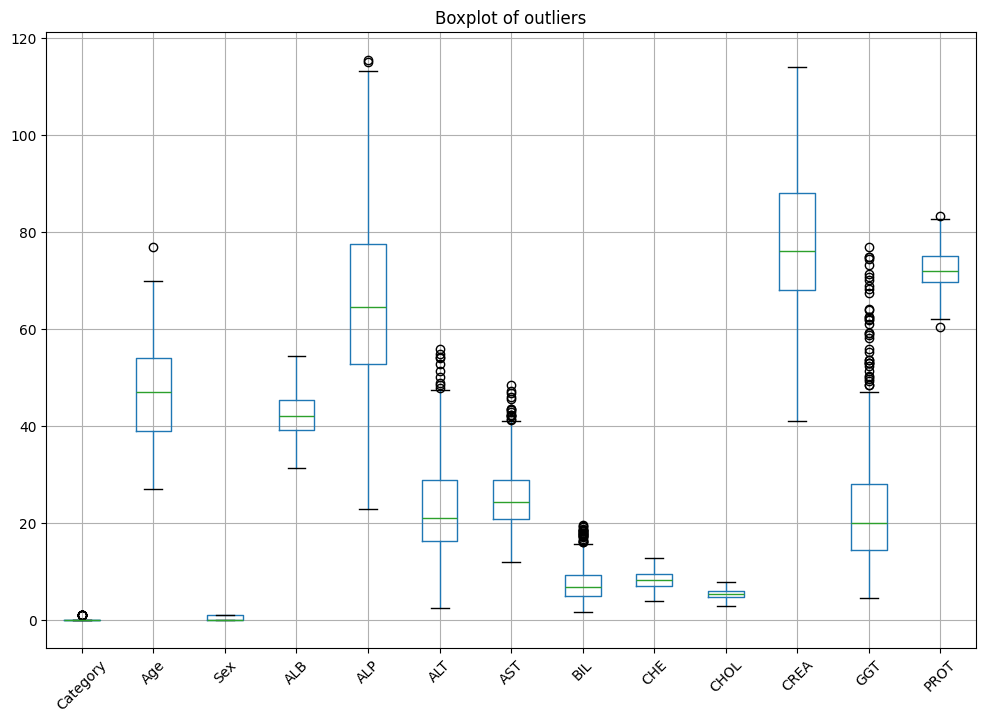

In [82]:
#We use a boxplot to see the outliers.
plt.figure(figsize=(12,8))  
data.boxplot()
plt.title("Boxplot of outliers")
plt.xticks(rotation=45)
plt.show()


In [83]:
data.describe()

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
count,448.0,448.000000,448.0,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000,448.000000
mean,0.029018,47.060268,0.441964,42.211607,65.752902,23.504687,25.252455,7.642857,8.290580,5.438125,78.025000,24.025223,72.243527
std,0.168044,9.543187,0.497176,4.200852,17.492071,10.159702,6.514904,3.837119,1.684943,0.947357,13.528206,14.029669,4.142868
min,0.0,27.000000,0.0,31.400000,22.900000,2.500000,12.000000,1.800000,3.900000,2.860000,41.000000,4.500000,60.500000
25%,0.0,39.000000,0.0,39.200000,52.850000,16.275000,20.775000,5.000000,7.100000,4.717500,68.000000,14.575000,69.750000
50%,0.0,47.000000,0.0,42.100000,64.550000,21.000000,24.300000,6.800000,8.280000,5.350000,76.000000,19.950000,72.050000
75%,0.0,54.000000,1.0,45.300000,77.500000,28.925000,28.925000,9.425000,9.462500,6.060000,88.000000,28.100000,75.100000
max,1.0,77.000000,1.0,54.400000,115.400000,55.900000,48.400000,19.700000,12.860000,7.800000,114.000000,76.900000,83.400000


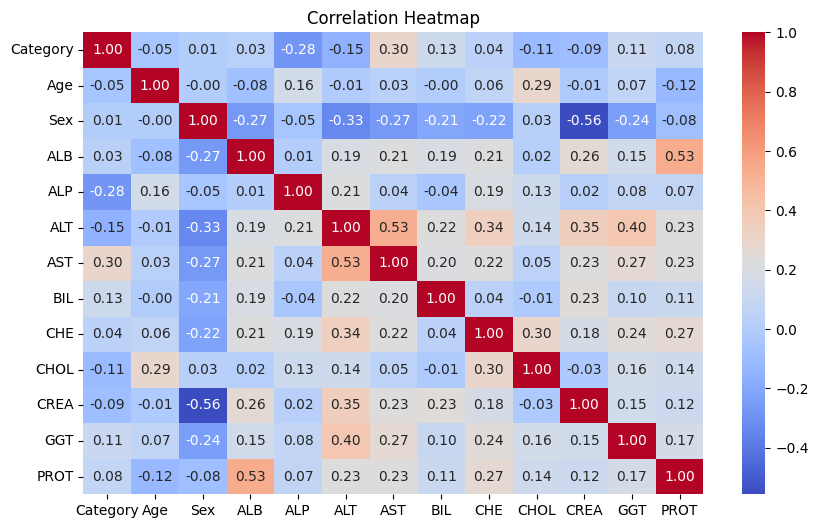

In [84]:
#Make use of visualizations to better understand the data and identify patterns or relationships between variables.
plt.figure(figsize=(10,6))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")    
plt.show()

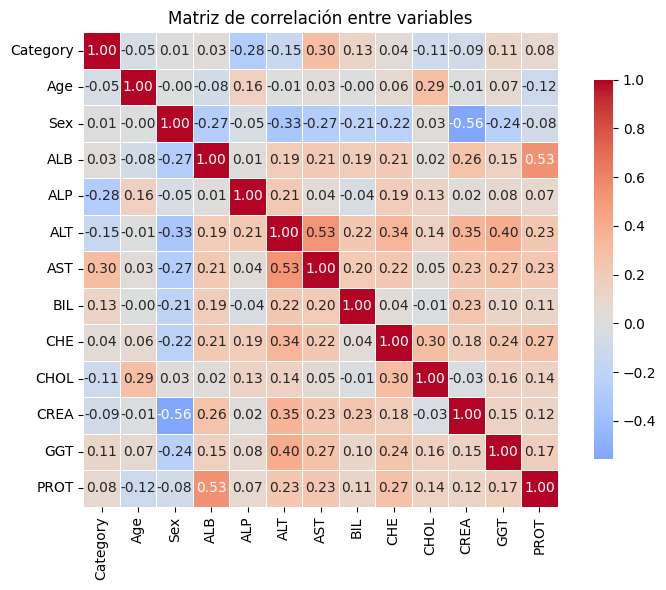

In [85]:
# Calcular la matriz de correlación
corr_matrix = data.corr()

# Crear un heatmap de la matriz de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0,
            linewidths=0.5, square=True, cbar_kws={"shrink": 0.8})
plt.title("Matriz de correlación entre variables")
plt.tight_layout()
plt.show()